# CASA0006 DSSS: Final Assessment

**Author:** Joe Post  
**Student Number:** 22186870  
**Date:** April 2023  

**[Github repository](https://github.com/joepost/casa0006_assessment)**  

---

# Predicting crash severity using New Zealand transport data

**Abstract:** This notebook ...

## 1. Introduction

### 1.1 Background 

Text ...

### 1.2 Literature Review

Text ...

### 1.3 Research Question

Text ...

## 2. Methodology

Text

## 3. Data Analysis

### 3.1 Setup
To conduct the analysis, the below packages need to be imported.

In [23]:
import numpy as np
import pandas as pd
import geopandas as gpd
import pysal as ps
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans, DBSCAN, OPTICS, AgglomerativeClustering

# preprocessors
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

# pipeline
from sklearn.pipeline import Pipeline

# CART
from sklearn.tree import DecisionTreeRegressor

# random forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

# xgboost
import xgboost
from xgboost import XGBRegressor
from xgboost import XGBClassifier

pd.set_option('display.max_rows', 300) # specifies number of rows to show
pd.options.display.float_format = '{:40,.4f}'.format # specifies default number format to 4 decimal places
plt.style.use('ggplot') # specifies that graphs should use ggplot styling
%matplotlib inline

### 3.2 Data cleaning
#### Read data
The CSV file is read in as a pandas data frame, and columns changed to the appropriate data types.

In [2]:
# Read in data
df = pd.read_csv("data/Crash_Analysis_System_CAS_data.csv", na_values = "Null")
df.shape

(807933, 72)

#### Data exploration
The table below shows the default data type of imported columns, and a count of non-null values for each column. There are 807,933 observations (rows) in the dataset, and 72 features (columns).  

In [3]:
# df.dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 807933 entries, 0 to 807932
Data columns (total 72 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   X                          807933 non-null  float64
 1   Y                          807933 non-null  float64
 2   OBJECTID                   807933 non-null  int64  
 3   advisorySpeed              30681 non-null   float64
 4   areaUnitID                 807883 non-null  float64
 5   bicycle                    807928 non-null  float64
 6   bridge                     325939 non-null  float64
 7   bus                        807928 non-null  float64
 8   carStationWagon            807928 non-null  float64
 9   cliffBank                  325939 non-null  float64
 10  crashDirectionDescription  503841 non-null  object 
 11  crashFinancialYear         807933 non-null  object 
 12  crashLocation1             807933 non-null  object 
 13  crashLocation2             80

Of these, 7 have a very high proportion of missing data (>90% of observations) - they are `advisorySpeed`, `crashRoadSideRoad`, `holiday`, `intersection`, `pedestrian`, `temporarySpeedLimit`, and `weatherB`. Through background reading of the [metadata](https://opendata-nzta.opendata.arcgis.com/pages/cas-data-field-descriptions), and investigation of the data, it can be seen that these columns contain a mix of true missing data and incorrectly coded real data. For example, `pedestrian` is defined as a "\[d\]erived variable to indicate how many pedestrians were involved in the crash. This includes pedestrians on skateboards, scooters and wheelchairs." However, non-missing values for `pedestrian` range from \[1,6\], meaning that no crash events have a value of '0' recorded. It is reasonable to assume that crashes with a null value for `pedestrian` actually represent events where no pedestrians were involved, as opposed to events where the number of pedestrians involved were not known or not recorded. Similarly, `holiday` only records an entry if the event falls into one of the four categories of Christmas/New Year, Easter, Labour Weekend, or Queens Birthday. Missing data in this column therefore likely represent events that occurred outside of these holiday dates. For `temporarySpeedLimit` and `advisorySpeed`, missing data represents a true absence - in these cases, no temporary or advisory speed limit was in effect at the time and location of the crash event. 

However, the columns `crashRoadSideRoad` and `intersection` are missing all data, and these were removed from the analysis. For `weatherB`, the observed possible values of 'Strong Wind', 'Frost', 'None' or missing do not align with the metadata description (where values are stated as 'Strong Wind', 'Frost' or 'Unknown'). Due to the ambiguity between 'None' and missing data, this column has been removed. 

Finally, free-text columns have been removed as these will not be useful in the ML model, as well as a series of redundant fields where the information is contained in another variable. These are `OBJECTID`, `areaUnitID`, `crashDirectionDescription`, `crashFinancialYear`, `crashLocation1`, `crashLocation2`, `crashFinancialYear`, `meshblockId`, `tlaName` and `tlaId`.

In [4]:
checkmissing = df[["pedestrian", "advisorySpeed", 
                   # "holiday", "weatherB",        #commented out as these are non-numeric columns; see cells below
                   "crashRoadSideRoad", "intersection", "temporarySpeedLimit"]]
checkmissing.describe()

,pedestrian,advisorySpeed,crashRoadSideRoad,intersection,temporarySpeedLimit
count,"25,977.0000","30,681.0000",0.0000,0.0000,"12,117.0000"
mean,1.0398,54.4392,NaN,NaN,45.7801
std,0.2309,18.1763,NaN,NaN,19.0041
min,1.0000,10.0000,NaN,NaN,8.0000
25%,1.0000,40.0000,NaN,NaN,30.0000
50%,1.0000,55.0000,NaN,NaN,40.0000
75%,1.0000,65.0000,NaN,NaN,60.0000
max,6.0000,95.0000,NaN,NaN,100.0000


In [5]:
df['holiday'].unique()

array([nan, 'Easter', 'Christmas New Year', 'Labour Weekend',
       'Queens Birthday'], dtype=object)

In [6]:
df['weatherB'].unique()

array([nan, 'Strong wind', 'Frost', 'None'], dtype=object)

In [7]:
df.drop(columns=['OBJECTID', 'areaUnitID', 'crashRoadSideRoad', 'crashDirectionDescription', 'crashFinancialYear', 'crashLocation1', 'crashLocation2', 'meshblockId', 'tlaName', 'tlaId', 'intersection', 'weatherB'], inplace=True)   # drop unwanted columns
df.pedestrian.fillna(value=0, inplace=True)     # replace missing pedestrian values with count of 0
df.holiday.fillna(value="None", inplace=True)   # replace missing holiday values with category 'None'
df.streetLight.fillna(value="Unknown", inplace=True)   # replace missing streetLight values with category 'Unknown'

A second subset of 23 columns have a non-null count of 325,939, meaning they are missing data for approximately 60% of observations. These are `bridge`, `cliffBank`, `debris`, `ditch`, `fence`, `guardRail`, `houseOrBuilding`, `kerb`, `objectThrownOrDropped`, `otherObject`, `overBank`, `parkedVehicle`, `phoneBoxEtc`, `postOrPole`, `roadworks`, `slipOrFlood`, `strayAnimal`, `trafficIsland`, `trafficSign`, `train`, `tree`, `vehicle`, and `waterRiver`. These columns all collect data on the number of objects of *type* that were struck in the crash, and are systematically either present or missing. 

In [8]:
# Set up list of columns with low/no missing data
columnsetA = ['bicycle', 'bus', 'carStationWagon',
           'crashSeverity', 'crashSHDescription', 'crashYear',
           'directionRoleDescription', 'fatalCount', 'flatHill', 'light',
           'minorInjuryCount', 'moped', 'motorcycle', 'NumberOfLanes',
           'otherVehicleType', 'pedestrian', 'region',
           'roadCharacter', 'roadLane', 'roadSurface', 'schoolBus',
           'seriousInjuryCount', 'speedLimit', 'streetLight', 'suv', 'taxi',
           'trafficControl', 'truck', 'unknownVehicleType', 'urban', 'vanOrUtility', 'weatherA']
    
# Set up list of columns with 60% missing data
columnsetB = ['bridge', 'cliffBank', 'debris', 'ditch', 'fence', 'guardRail',
           'houseOrBuilding', 'kerb', 'objectThrownOrDropped', 'otherObject', 'overBank',
           'parkedVehicle', 'phoneBoxEtc', 'postOrPole', 'roadworks', 'slipOrFlood', 'strayAnimal',
           'trafficIsland', 'trafficSign', 'train', 'tree','vehicle','waterRiver']

#### Set data types
Several columns in the dataset represent categorical data, where the input has been coded to one value out of a specific set - for example, the local government region where the crash occurred. Categorical columns in the dataframe are set accordingly, and the levels for each category checked to ensure it matches the metadata provided. 

The following columns are converted to categories:  
* `region`
* `crashSeverity`
* `crashSHDescription`
* `directionRoleDescription`
* `flatHill`
* `holiday`
* `light`
* `roadCharacter`
* `roadLane`
* `roadSurface`
* `streetLight`
* `trafficControl`
* `urban`
* `weatherA`
* `weatherB`

See below for a summary table (Table 1) of each categorical column, broken down proportionally by category. Tables 2 & 3 show the descriptive statistics for numeric variables, for column sets A and B, respectively.  

In [9]:
# Convert category columns to category type
df = df.astype({
    "region":"category",
    "crashSeverity":"category",
    "crashSHDescription":"category",
    "directionRoleDescription":"category",
    "flatHill":"category",
    "holiday":"category",
    "light":"category",
    "roadCharacter":"category",
    "roadLane":"category",
    "roadSurface":"category",
    "streetLight":"category",
    "trafficControl":"category",
    "urban":"category",
    "weatherA":"category"
})

catcols = ["region", "crashSeverity", "crashSHDescription", "directionRoleDescription", "flatHill",
    "holiday", "light", "roadCharacter", "roadLane", "roadSurface", "streetLight", "trafficControl", "urban", "weatherA"]

##### Table 1.  Categorical variables in crash dataset

In [10]:
# create loop of categorical variables to produce summary tables
for x in catcols:
    agg_df = df[[x, 'X']].groupby(x).count().rename(columns={'X':'count'}).sort_values('count', axis=0, ascending=False)
    total = agg_df.sum().values   # store the total as a value
    agg_df['percent'] = agg_df['count']/total*100   # calculate row-wise percentage
    print(agg_df)   # print table

                            count                                  percent
region                                                                    
Auckland Region            281105                                  34.9264
Waikato Region              86139                                  10.7025
Canterbury Region           80772                                  10.0357
Wellington Region           78436                                   9.7454
Bay of Plenty Region        46318                                   5.7549
Manawatū-Whanganui Region   45382                                   5.6386
Otago Region                43912                                   5.4559
Northland Region            32649                                   4.0565
Hawke's Bay Region          31768                                   3.9471
Southland Region            19927                                   2.4759
Taranaki Region             18252                                   2.2678
Gisborne Region          

##### Table 2. Numeric variables in crash data set (Set A: low/no missing data)

In [11]:
df[columnsetA].describe()

,bicycle,bus,carStationWagon,crashYear,fatalCount,minorInjuryCount,moped,motorcycle,NumberOfLanes,otherVehicleType,pedestrian,schoolBus,seriousInjuryCount,speedLimit,suv,taxi,truck,unknownVehicleType,vanOrUtility
count,"807,928.0000","807,928.0000","807,928.0000","807,933.0000","807,932.0000","807,932.0000","807,928.0000","807,928.0000","806,220.0000","807,928.0000","807,933.0000","807,928.0000","807,932.0000","807,183.0000","807,928.0000","807,928.0000","807,928.0000","807,928.0000","807,928.0000"
mean,0.0289,0.0159,1.3134,"2,010.6156",0.0104,0.3162,0.0071,0.0359,2.3393,0.0051,0.0334,0.0007,0.0686,65.8579,0.1054,0.0107,0.0805,0.0028,0.1751
std,0.1709,0.1265,0.7841,6.4985,0.1167,0.6405,0.0845,0.1922,0.9421,0.0722,0.1880,0.0276,0.3003,22.4786,0.3267,0.1061,0.2838,0.0549,0.4092
min,0.0000,0.0000,0.0000,"2,000.0000",0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,0.0000,0.0000,1.0000,"2,005.0000",0.0000,0.0000,0.0000,0.0000,2.0000,0.0000,0.0000,0.0000,0.0000,50.0000,0.0000,0.0000,0.0000,0.0000,0.0000
50%,0.0000,0.0000,1.0000,"2,010.0000",0.0000,0.0000,0.0000,0.0000,2.0000,0.0000,0.0000,0.0000,0.0000,50.0000,0.0000,0.0000,0.0000,0.0000,0.0000
75%,0.0000,0.0000,2.0000,"2,016.0000",0.0000,0.0000,0.0000,0.0000,2.0000,0.0000,0.0000,0.0000,0.0000,100.0000,0.0000,0.0000,0.0000,0.0000,0.0000
max,5.0000,3.0000,11.0000,"2,022.0000",9.0000,34.0000,4.0000,8.0000,9.0000,3.0000,6.0000,3.0000,14.0000,110.0000,6.0000,5.0000,5.0000,3.0000,6.0000


##### Table 3. Numeric variables in crash data set (Set B: approx. 60% missing data)

In [12]:
df[columnsetB].describe()

,bridge,cliffBank,debris,ditch,fence,guardRail,houseOrBuilding,kerb,objectThrownOrDropped,otherObject,...,postOrPole,roadworks,slipOrFlood,strayAnimal,trafficIsland,trafficSign,train,tree,vehicle,waterRiver
count,"325,939.0000","325,939.0000","325,939.0000","325,939.0000","325,939.0000","325,939.0000","325,939.0000","325,939.0000","325,939.0000","325,939.0000",...,"325,939.0000","325,939.0000","325,939.0000","325,939.0000","325,939.0000","325,939.0000","325,939.0000","325,939.0000","325,939.0000","325,939.0000"
mean,0.0137,0.1061,0.0082,0.0946,0.2098,0.0769,0.0235,0.0352,0.0022,0.0234,...,0.1229,0.0028,0.0024,0.0032,0.0288,0.0485,0.0015,0.1010,0.0253,0.0100
std,0.1176,0.3093,0.0990,0.2950,0.4122,0.2723,0.1525,0.1851,0.0515,0.1533,...,0.3305,0.0549,0.0505,0.0606,0.1686,0.2163,0.0387,0.3047,0.1590,0.0997
min,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
50%,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
75%,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
max,4.0000,3.0000,7.0000,3.0000,3.0000,4.0000,2.0000,3.0000,4.0000,5.0000,...,4.0000,2.0000,4.0000,3.0000,4.0000,4.0000,1.0000,3.0000,4.0000,2.0000


#### Dependent variable
The outcome variable of interest for this study is the crash severity, which is measured by three variables: 
1. `crashSeverity`: categorised as Non-injury Crash, Minor Crash, Serious Crash, or Fatal Crash
1. `seriousInjuryCount`: count of the serious injuries associated with this crash
1. `fatalCount`: count of the fatal casualties associated with this crash

As fatal count and serious injury count are both heavily skewed towards zero, crash severity category will be used as the main dependent variable for the ML model. 

[Text(0.5, 1.0, 'Crashes by severity category'),
 Text(0.5, 0, 'Severity'),
 Text(0, 0.5, 'Count')]

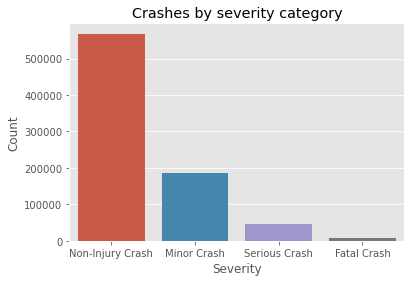

In [13]:
sns.countplot(data=df, x='crashSeverity', order=['Non-Injury Crash', 'Minor Crash', 'Serious Crash', 'Fatal Crash']).set(title="Crashes by severity category", xlabel="Severity", ylabel="Count")

#### Spatial conversion
The pandas dataframe is converted into a geopandas geodataframe, using the X/Y coordinates provided. These coordinates represent Easting/Northing values in the [NZTM2000](https://www.linz.govt.nz/guidance/geodetic-system/coordinate-systems-used-new-zealand/projections/new-zealand-transverse-mercator-2000-nztm2000) projection, which has the [EPSG code 2193](https://spatialreference.org/ref/epsg/2193/). The geodataframe is then plotted to confirm that the projection has been read as expected. 

In [14]:
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.X, df.Y), crs = "EPSG:2193") 

<AxesSubplot:>

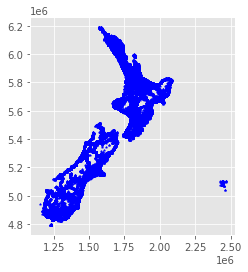

In [13]:
gdf.plot(marker='*', color='blue', markersize=5)

### 3.X Fitting and evaluating a model
#### Training Testing Split
The first step in preparing a machine learning model is to split the dataset into a training and testing subsets. 

In [15]:
gdfX = gdf.drop(columns=['crashSeverity', 'seriousInjuryCount', 'fatalCount'])
gdfY = gdf.crashSeverity

random_state_split = 100
train_x, test_x, train_y, test_y = train_test_split(gdfX, gdfY, random_state=random_state_split)

In [16]:
print(f"Full dataset size: {gdf.shape}")

print("Training dataset size:")
print(train_x.shape)
print(train_y.shape)
      
print("Test dataset size:")
print(test_x.shape)
print(test_y.shape)

Full dataset size: (807933, 61)
Training dataset size:
(605949, 58)
(605949,)
Test dataset size:
(201984, 58)
(201984,)


#### Model Pipeline
To prepare the data for modelling, two pre-processing steps are run: imputation of missing values, and standardisation of numeric variables. Imputation replaces missing observations with the *median* value for that feature; median has been chosen over mean due to the numeric variables being heavily skewed towards zero. For categorical values, missing observations are replaced with the mode category. After defining the pre-processing steps, an estimator is added to the ML pipeline, which specifies the ML algorithms to be used. For this project, a remote forest classifier (Breiman 2001) has been chosen. 

**NOTE: Need to clarify**
* Is one-hot encoding necessary for RandomForest? (appears not to be; in fact can be detrimental)
* Attempt to run an RF model independently (without using pipeline method). See if error still occurs
* Additional steps - incorporate spatial dependence explicity into model, as in the case of *Effati (2015)*; this would involve calculating a new column of spatial autocorrelation, and including this as a feature in the ML (I think...)
* From [sklearn documentation](https://scikit-learn.org/stable/modules/tree.html#tips-on-practical-use): Balance your dataset before training to prevent the tree from being biased toward the classes that are dominant. Class balancing can be done by sampling an equal number of samples from each class, or preferably by normalizing the sum of the sample weights (sample_weight) for each class to the same value. Also note that weight-based pre-pruning criteria, such as min_weight_fraction_leaf, will then be less biased toward dominant classes than criteria that are not aware of the sample weights, like min_samples_leaf.
* If the samples are weighted, it will be easier to optimize the tree structure using weight-based pre-pruning criterion such as min_weight_fraction_leaf, which ensure that leaf nodes contain at least a fraction of the overall sum of the sample weights.
* Further steps: PCA, validation (cross-validation?), hyperparameter tuning - is it best to focus on RF method and just perform tuning for this? 

In [18]:
# Define preprocessors
numeric_transformer = Pipeline(steps=[
       ('imputer', SimpleImputer(strategy='median')) # The missing values of a numeric feature will be replaced by the 'median'
      ,('scaler', StandardScaler())                  # standardises the values
])
categorical_transformer = Pipeline(steps=[
       ('imputer', SimpleImputer(strategy='most_frequent'))  # The missing values of a categorical feature will be replaced by the mode (most frequent) category.
      ,('encoder', OneHotEncoder(drop='first'))         # drop 'first' refers to dropping the first of each category to use as the reference
])

In [19]:
# Prepare numeric and categorical column lists
numcols = list(set(columnsetA) - set(catcols)) + columnsetB   # create list of numeric columns
numcols.remove('seriousInjuryCount')   # remove the dependent variables  *NOTE: should these just be removed in the cleaning section?
numcols.remove('fatalCount')           # remove the dependent variables
catcols.remove('crashSeverity')        # remove the dependent variable

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numeric_transformer, numcols),          # tuple that sets out the name, the transformer to use, and the set of columns to include
        ('categorical', categorical_transformer, catcols)
    ])

In [33]:
# Combine preprocessor into pipeline
pipeline = Pipeline(steps = [
   ('preprocessor', preprocessor),
   ('regressor', RandomForestClassifier())  # sets RF with default hyperparameters
])

rf_model = pipeline.fit(train_x, train_y)
# this will visualise the pipeline
print(rf_model)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['bicycle', 'schoolBus',
                                                   'motorcycle', 'pedestrian',
                                                   'vanOrUtility', 'moped',
                                                   'minorInjuryCount',
                                                   'crashYear',
                                                   'unknownVehicleType',
                                                   'carStationWagon',
                                                   'N

In [30]:
# Evaluate random forest model
print(f"Training score: {rf_model.score(train_x, train_y)}")
print(f"Test score: {rf_model.score(test_x, test_y)}")

Training score: 0.9966960915852654
Test score: 0.9380445975918885


### 3.X Interpreting feature importance

Permutation feature importance (PFI) method. 

### 3.X Principal Components Analysis (PCA)
PCA is a dimensionality reduction method, which is a technique to reduce the number of features under consideration. This has the benefit of reducing computation load and storage space when working with large datasets, and reduces the likelihood of overfitting when training a machine learning model. 

To perform PCA, first the dependent/outcome variable is removed from the dataset.  

**FOR NOW, this is `crashSeverity`**. Highly-related variables such as `seriousInjuryCount` and `fatalCount` have also been removed. 

In [ ]:
# Separate the predictor and outcome data
X = df.drop(columns=['seriousInjuryCount', 'crashSeverity', 'fatalCount']).values  #produce an array, for input into PCA function (as opposed to df)

## 4. Discussion

Text ...


## 5. Conclusion

Text ...


## References

1. Breiman, L. (2001) ‘Random Forests’, *Machine Learning*, 45(1), pp. 5–32. Available at: https://doi.org/10.1023/A:1010933404324.
